In [ ]:
import torch
import numpy as np
import torch.nn as nn
import math
from torch.optim.optimizer import Optimizer
from google.colab import files

In [ ]:
version_higher = (torch.__version__ >= "1.5.0")

class MAdam(Optimizer):
    def __init__(self, params, lr=1e-03, betas=(0.9, 0.999, 0.9), eps=1e-16,
                 weight_decay=0, amsgrad=False, weight_decouple=True, rectify=True, 
                 degenerated_to_sgd=True, fixed_decay=False):
        if not 0.0 <= lr:
            raise ValueError("Invalid learning rate: {}".format(lr))
        if not 0.0 <= eps:
            raise ValueError("Invalid epsilon value: {}".format(eps))
        if not 0.0 <= betas[0] < 1.0:
            raise ValueError("Invalid beta parameter at index 0: {}".format(betas[0]))
        if not 0.0 <= betas[1] < 1.0:
            raise ValueError("Invalid beta parameter at index 1: {}".format(betas[1]))
        if not 0.0 <= weight_decay:
            raise ValueError("Invalid weight_decay value: {}".format(weight_decay))

        if isinstance(params, (list, tuple)) and len(params) > 0 and isinstance(params[0], dict):
            for param in params:
                if 'betas' in param and (param['betas'][0] != betas[0] or param['betas'][1] != betas[1]):
                    param['buffer'] = [[None, None, None] for _ in range(10)]

        defaults = dict(lr=lr, betas=betas, eps=eps,
                        weight_decay=weight_decay, amsgrad=amsgrad, buffer=[[None, None, None] for _ in range(10)])
        super(MAdam, self).__init__(params, defaults)

        self.weight_decouple = weight_decouple
        self.rectify = rectify
        self.degenerated_to_sgd = degenerated_to_sgd
        self.fixed_decay = fixed_decay

    def __setstate__(self, state):
        super(MAdam, self).__setstate__(state)
        for group in self.param_groups:
            group.setdefault('amsgrad', False)

    def step(self, closure=None):
        """Performs a single optimization step.
        Arguments:
            closure (callable, optional): A closure that reevaluates the model
                and returns the loss.
        """
        loss = None
        if closure is not None:
            loss = closure()

        for group in self.param_groups:
            for p in group['params']:
                if p.grad is None:
                    continue

                grad = p.grad.data
                if grad.is_sparse:
                    raise RuntimeError(
                        'NAdam does not support sparse gradients, please consider SparseAdam instead')
                amsgrad = group['amsgrad']

                state = self.state[p]

                beta1, beta2, beta3 = group['betas']

                # State initialization
                if len(state) == 0:
                    state['step'] = 0
                    # Exponential moving average of gradient values
                    state['exp_avg'] = torch.zeros_like(p.data, memory_format=torch.preserve_format) \
                        if version_higher else torch.zeros_like(p.data)
                    # Exponential moving average of squared gradient values
                    state['exp_avg_var'] = torch.zeros_like(p.data, memory_format=torch.preserve_format) \
                        if version_higher else torch.zeros_like(p.data)

                    if amsgrad:
                        # Maintains max of all exp. moving avg. of sq. grad. values
                        state['max_exp_avg_var'] = torch.zeros_like(p.data, memory_format=torch.preserve_format) \
                            if version_higher else torch.zeros_like(p.data)

                # get current state variable
                exp_avg, exp_avg_var = state['exp_avg'], state['exp_avg_var']

                state['step'] += 1
                bias_correction1 = 1 - beta1 ** state['step']
                bias_correction2 = 1 - beta2 ** state['step']
                
                exp_avg.mul_(beta1).add_(grad, alpha=1 - beta1)
                grad_diff = (grad - exp_avg) / beta1
                grad.mul_(beta3).add_(grad_diff, alpha=1- beta3)
                exp_avg_var.mul_(beta2).addcmul_(grad, grad, value=1 - beta2)


                if amsgrad:
                    max_exp_avg_var = state['max_exp_avg_var']
                    # Maintains the maximum of all 2nd moment running avg. till now
                    torch.max(max_exp_avg_var, exp_avg_var, out=max_exp_avg_var)

                    # Use the max. for normalizing running avg. of gradient
                    denom = (max_exp_avg_var.sqrt() / math.sqrt(bias_correction2)).add_(group['eps'])

                else:
                    denom = (exp_avg_var.sqrt() / math.sqrt(bias_correction2)).add_(group['eps'])

                # perform weight decay, check if decoupled weight decay
                if self.weight_decouple:
                    if not self.fixed_decay:
                        p.data.mul_(1.0 - group['lr'] * group['weight_decay'])
                    else:
                        p.data.mul_(1.0 - group['weight_decay'])
                else:
                    if group['weight_decay'] != 0:
                        grad.add_(p.data, alpha=group['weight_decay'])

                # Update
                if not self.rectify:
                    # Default update
                    step_size = group['lr'] / bias_correction1
                    p.data.addcdiv_(exp_avg, denom, value=-step_size)

                else:  # Rectified update, forked from RAdam
                    buffered = group['buffer'][int(state['step'] % 10)]
                    if state['step'] == buffered[0]:
                        N_sma, step_size = buffered[1], buffered[2]
                    else:
                        buffered[0] = state['step']
                        beta2_t = beta2 ** state['step']
                        N_sma_max = 2 / (1 - beta2) - 1
                        N_sma = N_sma_max - 2 * state['step'] * beta2_t / (1 - beta2_t)
                        buffered[1] = N_sma

                        # more conservative since it's an approximated value
                        if N_sma >= 5:
                            step_size = math.sqrt(
                                (1 - beta2_t) * (N_sma - 4) / (N_sma_max - 4) * (N_sma - 2) / N_sma * N_sma_max / (
                                        N_sma_max - 2)) / (1 - beta1 ** state['step'])
                        elif self.degenerated_to_sgd:
                            step_size = 1.0 / (1 - beta1 ** state['step'])
                        else:
                            step_size = -1
                        buffered[2] = step_size

                    if N_sma >= 5:
                        denom = exp_avg_var.sqrt().add_(group['eps'])
                        p.data.addcdiv_(exp_avg, denom, value=-step_size * group['lr'])
                    elif step_size > 0:
                        p.data.add_(exp_avg, alpha=-step_size * group['lr'])

        return loss

In [ ]:
import torchvision
import torchvision.transforms as transforms

In [ ]:
normalize = transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
train_transform = transforms.Compose([transforms.Resize(256),
                                      transforms.RandomResizedCrop(224), 
                                      transforms.RandomHorizontalFlip(), 
                                      transforms.ToTensor(),
                                      normalize])
test_transform = transforms.Compose([transforms.Resize(256),
                                     transforms.CenterCrop(224),
                                     transforms.ToTensor(),
                                     normalize])

In [ ]:
batch_size = 100
trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=train_transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size,
                                          shuffle=True, num_workers=2)

testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                       download=True, transform=test_transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size,
                                         shuffle=False, num_workers=2)

Extracting ./data/cifar-10-python.tar.gz to ./data
Files already downloaded and verified


In [ ]:
import time

def timeSince(since):
    now = time.time()
    s = now - since
    m = s // 60
    s -= m * 60
    return '%dm %ds' % (m, s)

In [ ]:
import torchvision.models as models

In [ ]:
def evaluateImageModel(model, data, criterion, device):
    model.eval()
    total_loss = 0.0
    correct = 0
    total = 0
    with torch.no_grad():
        for image, labels in data:
            image, labels = image.to(device), labels.to(device)
            output = model(image)
            pred = torch.argmax(output, dim=1)
            correct += (pred == labels).sum().item()
            total += len(labels)
            loss = criterion(output, labels)
            total_loss += loss.item()

    return total_loss / len(data), 1 - correct / total

def trainImageModel(model, train_data, val_data, n_epochs, criterion, optimizer, device, path):
    model.train()
    train_error_list = []
    val_error_list = []
    min_error = None
    step = 0
    print_every = len(train_data)
    start = time.time()
    for epoch in range(n_epochs):
        running_loss = 0.0
        running_correct = 0
        running_total = 0
        for image, labels in train_data:
            optimizer.zero_grad()
            step += 1
            image, labels = image.to(device), labels.to(device)
            output = model(image)
            pred = torch.argmax(output, dim=1)
            running_correct += (pred == labels).sum().item()
            running_total += len(labels)
            loss = criterion(output, labels)
            running_loss += loss.item()
            loss.backward()
            optimizer.step()
            if step % print_every == 0:
                val_loss, val_error = evaluateImageModel(model, val_data, criterion, device)
                print(('%d/%d (%s) train loss: %.3f, train error: %.2f%%, val loss: %.3f, val error: %.2f%%') %
                      (epoch + 1, n_epochs, timeSince(start), running_loss / len(train_data), 
                       100 *(1 - running_correct / running_total), val_loss, 100 * val_error))
                train_error_list.append(1 - running_correct / running_total)
                val_error_list.append(val_error)
                if min_error is None or min_error > val_error:
                    if min_error is None:
                        print(('Validation error rate in first epoch: %.2f%%') % (100 * val_error))
                    else:
                        print(('Validation error rate is decreasing: %.2f%% --> %.2f%%') % 
                              (100 * min_error, 100 * val_error))
                    min_error = val_error
                    print('Saving model...')
                    torch.save(model, path)
                
                model.train()
                running_loss = 0.0
                running_correct = 0
                running_total = 0
    
    return train_error_list, val_error_list

In [ ]:
model = models.resnet34()
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
criterion = nn.CrossEntropyLoss()
n_epochs = 100
nadam_train_list = None
nadam_test_list = None
optimizer = MAdam(model.parameters())
model.to(device)
path = 'madamRes.pt'
nadam_train_list, nadam_test_list = trainImageModel(model, trainloader, testloader,
                                                    n_epochs, criterion, optimizer,
                                                    device, path)
torch.save(nadam_train_list, 'madamres_train.pt')
torch.save(nadam_test_list, 'madamres_test.pt')

1/100 (1m 48s) train loss: 1.947, train error: 64.59%, val loss: 2.017, val error: 61.93%
Validation error rate in first epoch: 61.93%
Saving model...
2/100 (3m 39s) train loss: 1.378, train error: 49.25%, val loss: 1.345, val error: 46.29%
Validation error rate is decreasing: 61.93% --> 46.29%
Saving model...
3/100 (5m 28s) train loss: 1.186, train error: 42.07%, val loss: 0.874, val error: 30.81%
Validation error rate is decreasing: 46.29% --> 30.81%
Saving model...
4/100 (7m 15s) train loss: 1.074, train error: 37.73%, val loss: 1.016, val error: 33.22%
5/100 (9m 4s) train loss: 0.999, train error: 35.21%, val loss: 0.773, val error: 26.36%
Validation error rate is decreasing: 30.81% --> 26.36%
Saving model...
6/100 (10m 56s) train loss: 0.935, train error: 32.82%, val loss: 0.747, val error: 25.40%
Validation error rate is decreasing: 26.36% --> 25.40%
Saving model...
7/100 (12m 45s) train loss: 0.891, train error: 31.04%, val loss: 0.730, val error: 25.87%
8/100 (14m 36s) train lo

In [ ]:
files.download('nadamres_train.pt')
files.download('nadamres_test.pt')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
model = models.shufflenet_v2_x1_0()
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
criterion = nn.CrossEntropyLoss()
n_epochs = 100
nadam_train_list = None
nadam_test_list = None
optimizer = MAdam(model.parameters())
model.to(device)
path = 'madamRes.pt'
nadam_train_list, nadam_test_list = trainImageModel(model, trainloader, testloader,
                                                    n_epochs, criterion, optimizer,
                                                    device, path)
torch.save(nadam_train_list, 'madamshuffle_train.pt')
torch.save(nadam_test_list, 'madamshuffle_test.pt')

1/100 (1m 36s) train loss: 2.178, train error: 71.13%, val loss: 1.568, val error: 60.22%
Validation error rate in first epoch: 60.22%
Saving model...
2/100 (3m 19s) train loss: 1.608, train error: 58.77%, val loss: 1.323, val error: 48.98%
Validation error rate is decreasing: 60.22% --> 48.98%
Saving model...
3/100 (4m 57s) train loss: 1.429, train error: 51.73%, val loss: 1.172, val error: 42.13%
Validation error rate is decreasing: 48.98% --> 42.13%
Saving model...
4/100 (6m 37s) train loss: 1.276, train error: 45.36%, val loss: 0.936, val error: 33.40%
Validation error rate is decreasing: 42.13% --> 33.40%
Saving model...
5/100 (8m 18s) train loss: 1.144, train error: 40.90%, val loss: 0.815, val error: 28.74%
Validation error rate is decreasing: 33.40% --> 28.74%
Saving model...
6/100 (10m 2s) train loss: 1.057, train error: 37.29%, val loss: 0.758, val error: 26.05%
Validation error rate is decreasing: 28.74% --> 26.05%
Saving model...
7/100 (11m 40s) train loss: 0.987, train err

In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
n_epochs = 100
criterion = nn.CrossEntropyLoss()
train_list = None
test_list = None
model = models.mobilenet_v2()
optimizer = MAdam(model.parameters())
model.to(device)
name = 'madammobile'
path = name + '.pt'
train_list, test_list = trainImageModel(model, trainloader, testloader, n_epochs, criterion, optimizer, device, path)
torch.save(train_list, name + '_train.pt')
torch.save(test_list, name + '_test.pt')
files.download(name + '_train.pt')
files.download(name + '_test.pt')

1/100 (1m 51s) train loss: 2.167, train error: 69.49%, val loss: 1.502, val error: 56.00%
Validation error rate in first epoch: 56.00%
Saving model...
2/100 (3m 45s) train loss: 1.526, train error: 55.29%, val loss: 1.498, val error: 49.96%
Validation error rate is decreasing: 56.00% --> 49.96%
Saving model...
3/100 (5m 38s) train loss: 1.357, train error: 48.65%, val loss: 1.001, val error: 35.59%
Validation error rate is decreasing: 49.96% --> 35.59%
Saving model...
4/100 (7m 31s) train loss: 1.241, train error: 43.89%, val loss: 0.917, val error: 31.49%
Validation error rate is decreasing: 35.59% --> 31.49%
Saving model...
5/100 (9m 26s) train loss: 1.136, train error: 40.41%, val loss: 0.828, val error: 29.09%
Validation error rate is decreasing: 31.49% --> 29.09%
Saving model...
6/100 (11m 18s) train loss: 1.049, train error: 36.94%, val loss: 0.757, val error: 26.21%
Validation error rate is decreasing: 29.09% --> 26.21%
Saving model...
7/100 (13m 12s) train loss: 0.987, train er

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
!nvidia-smi

Tue Dec 15 08:23:00 2020       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 455.45.01    Driver Version: 418.67       CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla V100-SXM2...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   49C    P0    54W / 300W |  15619MiB / 16130MiB |      0%      Default |
|                               |                      |                 ERR! |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [ ]:
!lsof /dev/nvidia*

COMMAND  PID USER   FD   TYPE  DEVICE SIZE/OFF  NODE NAME
python3 3224 root  mem    CHR 195,255          17360 /dev/nvidiactl
python3 3224 root  mem    CHR   195,0          17359 /dev/nvidia0
python3 3224 root  mem    CHR   246,0          17357 /dev/nvidia-uvm
python3 3224 root   59u   CHR 195,255      0t0 17360 /dev/nvidiactl
python3 3224 root   62u   CHR   246,0      0t0 17357 /dev/nvidia-uvm
python3 3224 root   63u   CHR   195,0      0t0 17359 /dev/nvidia0
python3 3224 root   64u   CHR   195,0      0t0 17359 /dev/nvidia0
python3 3224 root   65u   CHR   195,0      0t0 17359 /dev/nvidia0
python3 3224 root   70u   CHR   195,0      0t0 17359 /dev/nvidia0
python3 3224 root   71u   CHR   195,0      0t0 17359 /dev/nvidia0
python3 3224 root   72u   CHR   195,0      0t0 17359 /dev/nvidia0
python3 3224 root   75u   CHR   195,0      0t0 17359 /dev/nvidia0
python3 3224 root   76u   CHR   195,0      0t0 17359 /dev/nvidia0
python3 3224 root   77u   CHR   195,0      0t0 17359 /dev/nvidia0
python3 

In [ ]:
!kill -9 64

In [ ]:
import torch
import torch.nn as nn
from torch.nn import functional as F
from torchvision import datasets, transforms
from torchvision.utils import save_image
from IPython.display import Image, display
import matplotlib.pyplot as plt

# create directory to save results
!mkdir results

# script parameters
batch_size = 128
log_interval = 100

# run on GPU if possible
cuda = torch.cuda.is_available()
device = torch.device("cuda" if cuda else "cpu")

# create data loaders
kwargs = {'num_workers': 1, 'pin_memory': True} if cuda else {}
train_loader = torch.utils.data.DataLoader(
    datasets.MNIST('../data', train=True, download=True,
                   transform=transforms.ToTensor()),
    batch_size=batch_size, shuffle=True, **kwargs)
test_loader = torch.utils.data.DataLoader(
    datasets.MNIST('../data', train=False, transform=transforms.ToTensor()),
    batch_size=batch_size, shuffle=True, **kwargs)

Extracting ../data/MNIST/raw/train-images-idx3-ubyte.gz to ../data/MNIST/raw


Extracting ../data/MNIST/raw/train-labels-idx1-ubyte.gz to ../data/MNIST/raw



Extracting ../data/MNIST/raw/t10k-images-idx3-ubyte.gz to ../data/MNIST/raw


Extracting ../data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ../data/MNIST/raw
Processing...
Done!


/usr/local/lib/python3.6/dist-packages/torchvision/datasets/mnist.py:480: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  /pytorch/torch/csrc/utils/tensor_numpy.cpp:141.)
  return torch.from_numpy(parsed.astype(m[2], copy=False)).view(*s)


In [ ]:
# Generator Network
class Generator(nn.Module):

    # declare layers
    def __init__(self):
        super(Generator, self).__init__()

        self.fc1 = nn.Linear(20, 400)
        self.fc2 = nn.Linear(400, 784)

    # Forward: one ReLU hidden layer of 400 nodes, one Sigmoid output layer of 784 nodes
    def forward(self, z):
        h = F.relu(self.fc1(z))
        probabilities = F.sigmoid(self.fc2(h))
        return probabilities

# Discriminator Network
class Discriminator(nn.Module):

    # declare layers
    def __init__(self):
        super(Discriminator, self).__init__()

        self.fc1 = nn.Linear(784, 400)
        self.fc2 = nn.Linear(400, 1)

    # Forward: one ReLU hidden layer of 400 nodes, one Sigmoid output layer of 1 node
    def forward(self, x):
        h = F.relu(self.fc1(x))
        probabilities = F.sigmoid(self.fc2(h))
        return probabilities

In [ ]:
def gan_loss_function(predictions, targets):
    BCE = F.binary_cross_entropy(predictions, targets.view(targets.size(0), 1), reduction='sum')
    return BCE

In [ ]:
real_label = 1
fake_label = 0

def gan_train(epoch, generator, generator_optimizer, discriminator, discriminator_optimizer):
    generator_loss = 0.0
    discriminator_loss = 0.0
    generator.train()
    discriminator.train()
    for i, (data, _) in enumerate(train_loader):
        for k in range(1):
            # Update discriminator network
            discriminator.zero_grad()
            # Train all-real batch
            real_data = data.to(device)
            batch_size = real_data.size(0)
            label = torch.full((batch_size,), real_label, dtype=torch.float, device=device)
            output = discriminator(real_data.view(-1, 784))
            # Calulate loss on all-real batch
            errD_real = gan_loss_function(output, label)
            errD_real.backward()
            # Train all-fake batch
            noise = torch.randn(batch_size, 20, device=device)
            fake_data = generator(noise)
            label.fill_(fake_label)
            output = discriminator(fake_data.detach())
            # Calulate loss on all-fake batch
            errD_fake = gan_loss_function(output, label)
            errD_fake.backward()
            # Calulate total loss on real and fake batch
            errD = errD_real + errD_fake
            discriminator_loss += errD.item()
            discriminator_optimizer.step()
        
        # Update generator network
        generator.zero_grad()
        label.fill_(real_label)
        output = discriminator(fake_data)
        errG = gan_loss_function(output, label)
        errG.backward()
        generator_loss += errG.item()
        generator_optimizer.step()
        
    average_discriminator_loss = discriminator_loss / len(train_loader.dataset)
    average_generator_loss = generator_loss / len(train_loader.dataset)
    return average_generator_loss, average_discriminator_loss

In [ ]:
def gan_test(epoch, generator, discriminator):
    generator.eval()
    discriminator.eval()
    generator_loss = 0.0
    discriminator_loss = 0.0
    with torch.no_grad():
        for i, (data, _) in enumerate(test_loader):
            # Compute dicriminator loss
            # loss in all-real data
            real_data = data.to(device)
            batch_size = real_data.size(0)
            label = torch.full((batch_size,), real_label, dtype=torch.float, device=device)
            output = discriminator(real_data.view(-1, 784))
            errD_real = gan_loss_function(output, label)
            # loss in all-fake data
            noise = torch.randn(batch_size, 20, device=device)
            fake_data = generator(noise)
            label.fill_(fake_label)
            output = discriminator(fake_data)
            errD_fake = gan_loss_function(output, label)
            errD = errD_real + errD_fake
            discriminator_loss += errD.item()
            # Compute generator loss
            label.fill_(real_label)
            errG = gan_loss_function(output, label)
            generator_loss += errG.item()
            
    average_discriminator_loss = discriminator_loss / len(test_loader.dataset)
    average_generator_loss = generator_loss / len(test_loader.dataset)
    return average_generator_loss, average_discriminator_loss

/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:1639: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


1/50 Sample of generated images


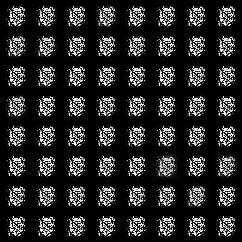



2/50 Sample of generated images


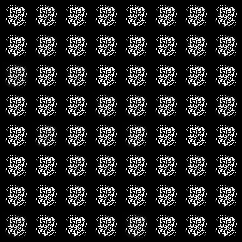



3/50 Sample of generated images


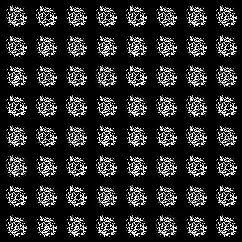



4/50 Sample of generated images


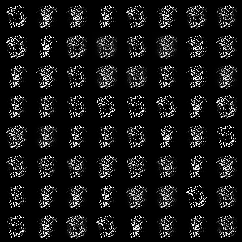



5/50 Sample of generated images


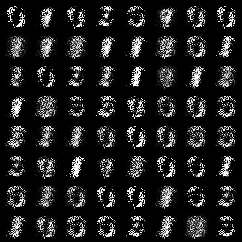



6/50 Sample of generated images


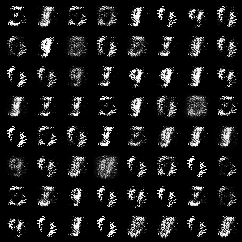



7/50 Sample of generated images


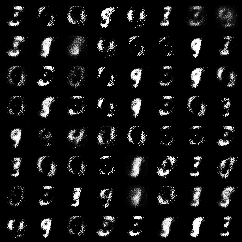



8/50 Sample of generated images


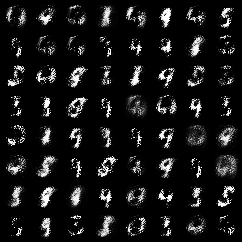



9/50 Sample of generated images


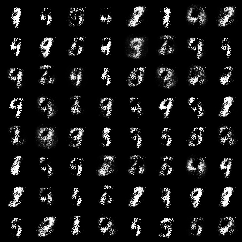



10/50 Sample of generated images


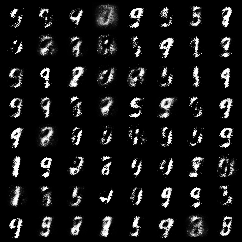



11/50 Sample of generated images


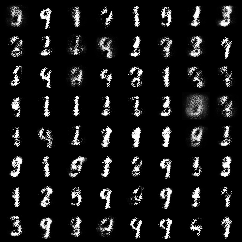



12/50 Sample of generated images


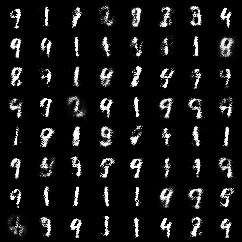



13/50 Sample of generated images


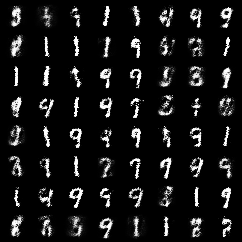



14/50 Sample of generated images


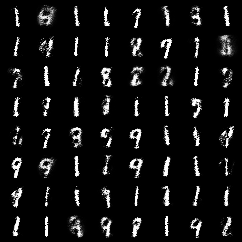



15/50 Sample of generated images


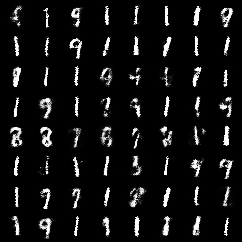



16/50 Sample of generated images


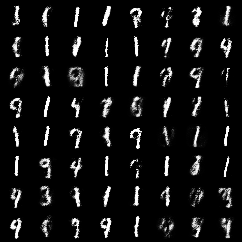



17/50 Sample of generated images


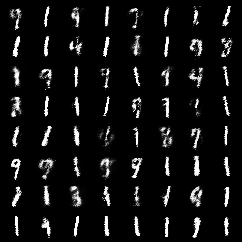



18/50 Sample of generated images


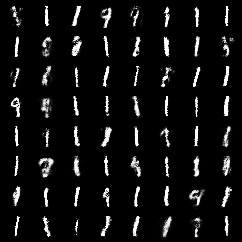



19/50 Sample of generated images


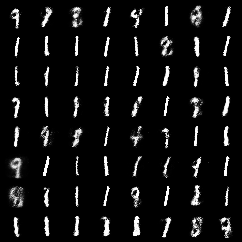



20/50 Sample of generated images


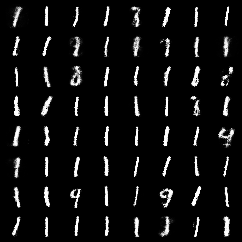



21/50 Sample of generated images


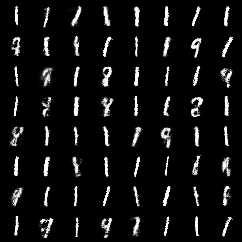



22/50 Sample of generated images


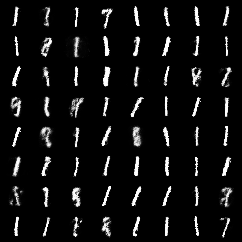



23/50 Sample of generated images


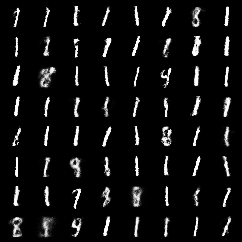



24/50 Sample of generated images


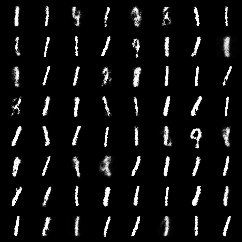



25/50 Sample of generated images


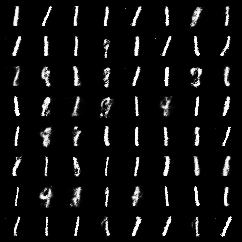



26/50 Sample of generated images


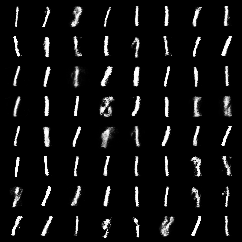



27/50 Sample of generated images


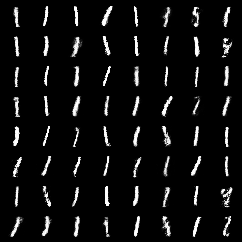



28/50 Sample of generated images


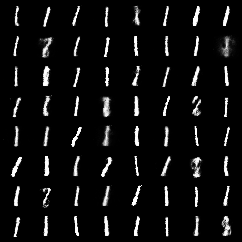



29/50 Sample of generated images


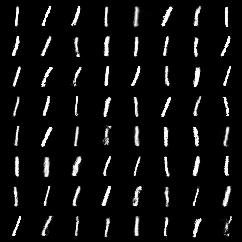



30/50 Sample of generated images


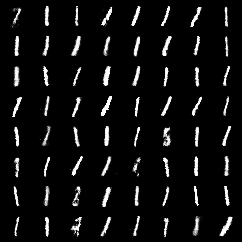



31/50 Sample of generated images


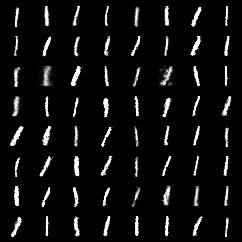



32/50 Sample of generated images


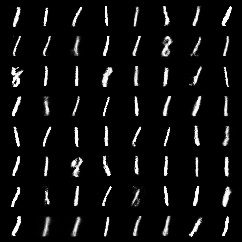



33/50 Sample of generated images


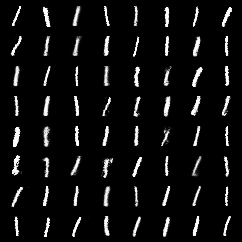



34/50 Sample of generated images


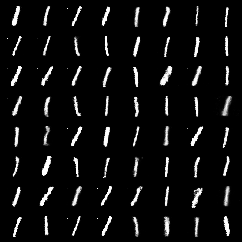



35/50 Sample of generated images


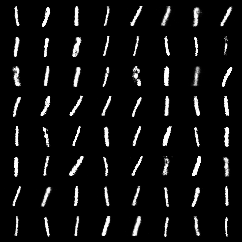



36/50 Sample of generated images


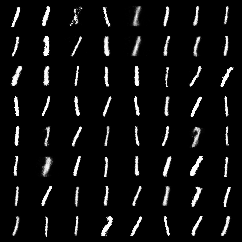



37/50 Sample of generated images


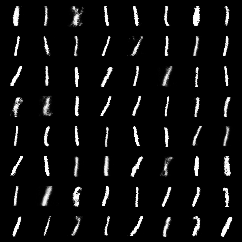



38/50 Sample of generated images


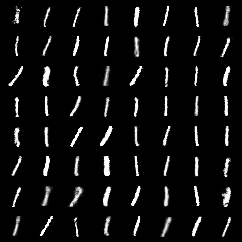



39/50 Sample of generated images


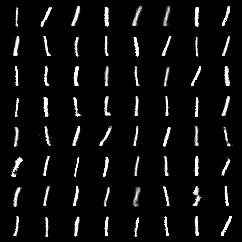



40/50 Sample of generated images


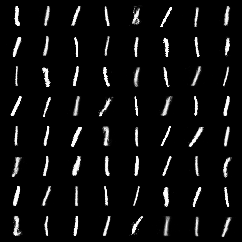



41/50 Sample of generated images


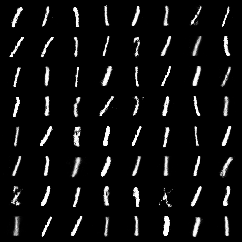



42/50 Sample of generated images


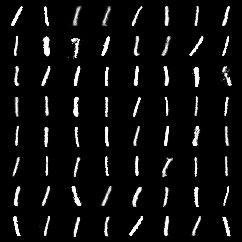



43/50 Sample of generated images


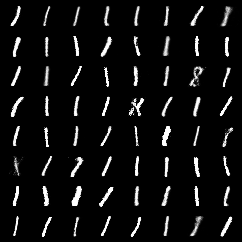



44/50 Sample of generated images


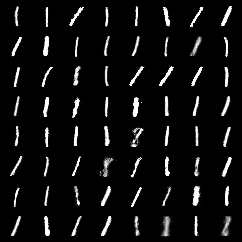



45/50 Sample of generated images


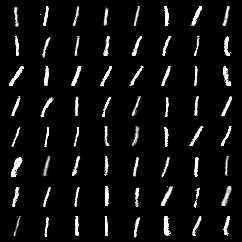



46/50 Sample of generated images


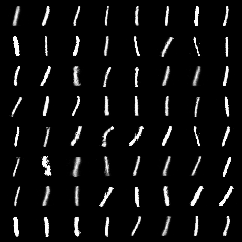



47/50 Sample of generated images


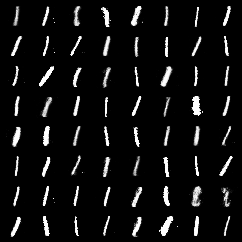



48/50 Sample of generated images


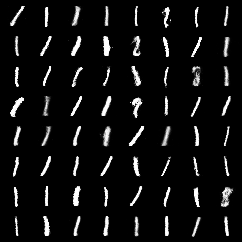



49/50 Sample of generated images


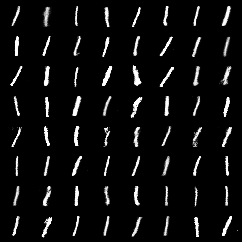



50/50 Sample of generated images


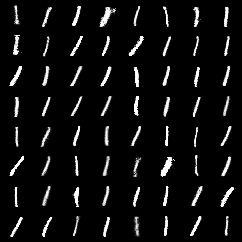

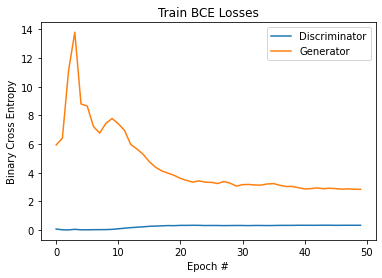

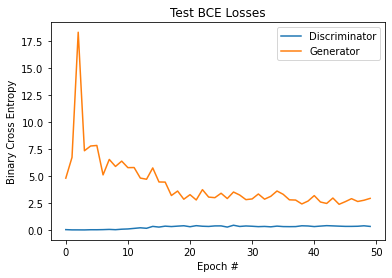

In [ ]:
epochs = 50
discriminator_average_train_losses = []
discriminator_average_test_losses = []
generator_average_train_losses = []
generator_average_test_losses = []
generator_model = Generator().to(device)
generator_optimizer = MAdam(generator_model.parameters(), lr=3e-3, betas=(0.9, 0.999, 5.4))
discriminator_model = Discriminator().to(device)
discriminator_optimizer = MAdam(discriminator_model.parameters(), lr=3e-3, betas=(0.9, 0.999, 5.4))
for epoch in range(1, epochs + 1):
    generator_average_train_loss, discriminator_average_train_loss = gan_train(epoch, generator_model, generator_optimizer, discriminator_model, discriminator_optimizer)
    discriminator_average_train_losses.append(discriminator_average_train_loss)
    generator_average_train_losses.append(generator_average_train_loss)
    generator_average_test_loss, discriminator_average_test_loss = gan_test(epoch, generator_model, discriminator_model)
    discriminator_average_test_losses.append(discriminator_average_test_loss)
    generator_average_test_losses.append(generator_average_test_loss)
    with torch.no_grad():
        print('%d/%d Sample of generated images' % (epoch, epochs))
        sample = torch.randn(64, 20).to(device)
        sample = generator_model(sample).cpu()
        if epoch == epochs:
            save_image(sample.view(64, 1, 28, 28),
                       'results/final_madam_sample.png')
            display(Image('results/final_madam_sample.png'))
        else:
            save_image(sample.view(64, 1, 28, 28),
                    'results/sample_' + str(epoch) + '.png')
            display(Image('results/sample_' + str(epoch) + '.png'))
        print('\n')

# Plot Train losses
plt.plot(discriminator_average_train_losses)
plt.plot(generator_average_train_losses)
plt.title('Train BCE Losses')
plt.ylabel('Binary Cross Entropy')
plt.xlabel('Epoch #')
plt.legend(['Discriminator','Generator'], loc='upper right')
plt.show()

# Plot Test Losses
plt.plot(discriminator_average_test_losses)
plt.plot(generator_average_test_losses)
plt.title('Test BCE Losses')
plt.ylabel('Binary Cross Entropy')
plt.xlabel('Epoch #')
plt.legend(['Discriminator','Generator'], loc='upper right')
plt.show()

torch.save(generator_average_test_losses, 'madam_gan_g_xlarge_lr.pt')

/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:1639: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


1/50 Sample of generated images


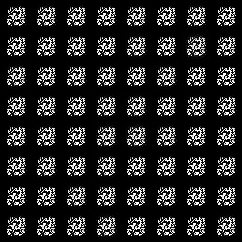



2/50 Sample of generated images


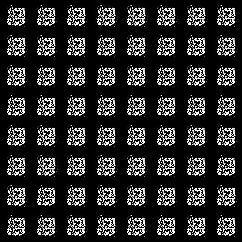



3/50 Sample of generated images


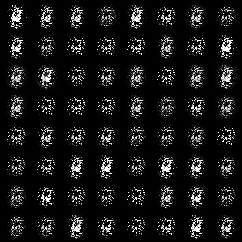



4/50 Sample of generated images


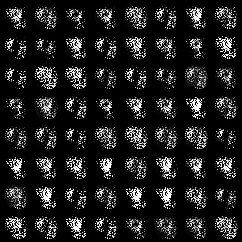



5/50 Sample of generated images


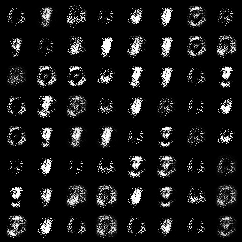



6/50 Sample of generated images


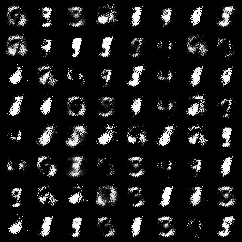



7/50 Sample of generated images


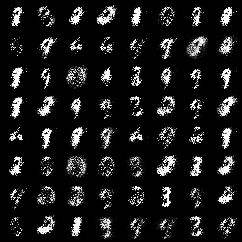



8/50 Sample of generated images


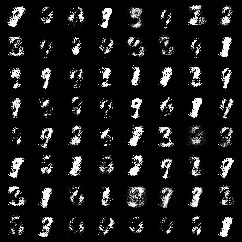



9/50 Sample of generated images


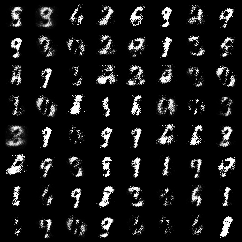



10/50 Sample of generated images


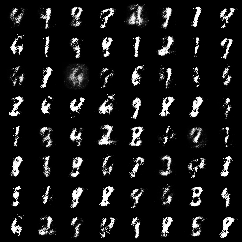



11/50 Sample of generated images


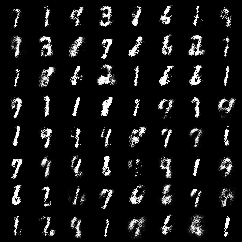



12/50 Sample of generated images


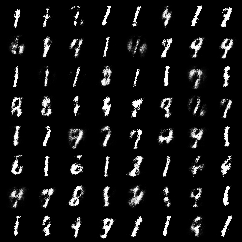



13/50 Sample of generated images


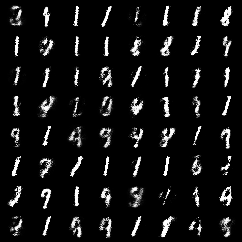



14/50 Sample of generated images


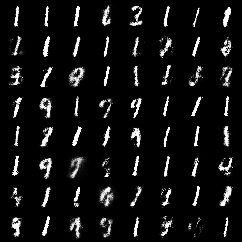



15/50 Sample of generated images


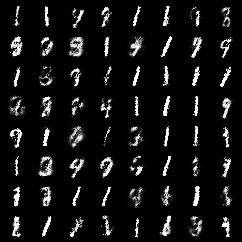



16/50 Sample of generated images


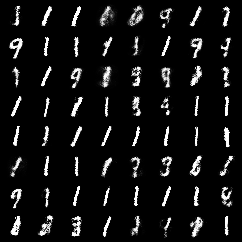



17/50 Sample of generated images


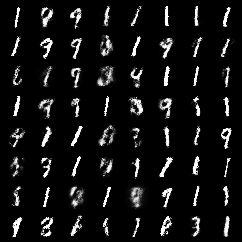



18/50 Sample of generated images


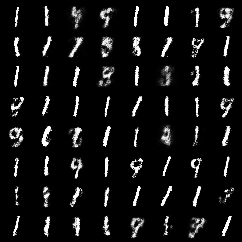



19/50 Sample of generated images


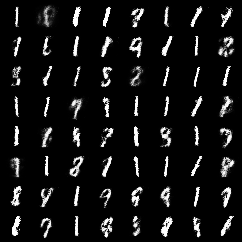



20/50 Sample of generated images


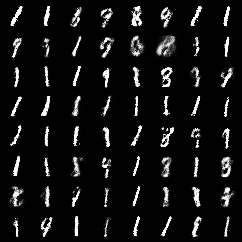



21/50 Sample of generated images


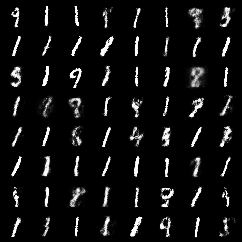



22/50 Sample of generated images


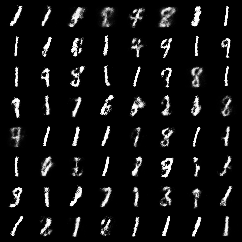



23/50 Sample of generated images


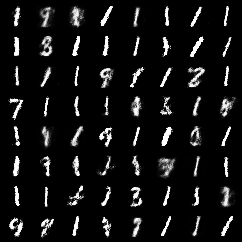



24/50 Sample of generated images


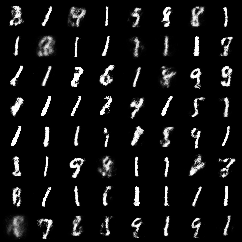



25/50 Sample of generated images


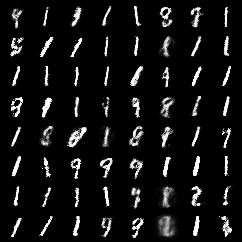



26/50 Sample of generated images


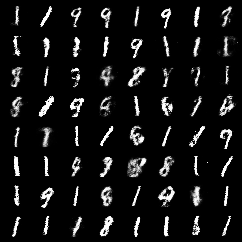



27/50 Sample of generated images


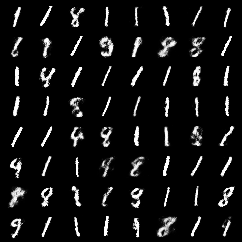



28/50 Sample of generated images


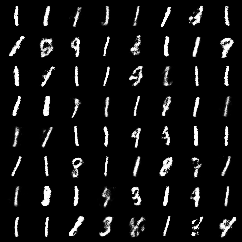



29/50 Sample of generated images


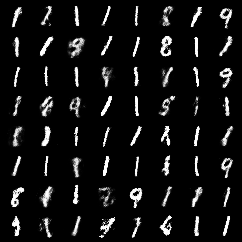



30/50 Sample of generated images


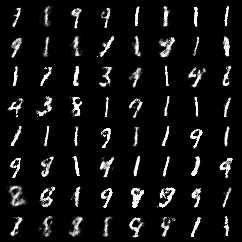



31/50 Sample of generated images


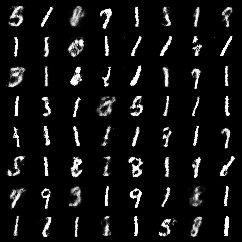



32/50 Sample of generated images


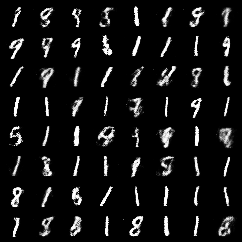



33/50 Sample of generated images


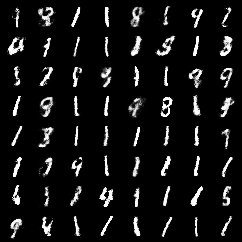



34/50 Sample of generated images


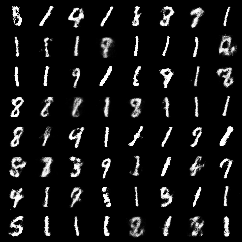



35/50 Sample of generated images


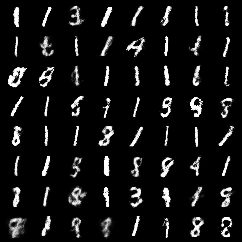



36/50 Sample of generated images


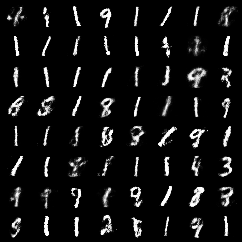



37/50 Sample of generated images


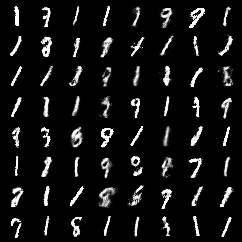



38/50 Sample of generated images


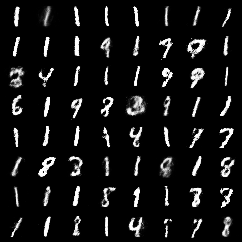



39/50 Sample of generated images


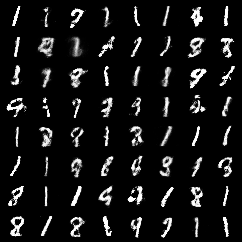



40/50 Sample of generated images


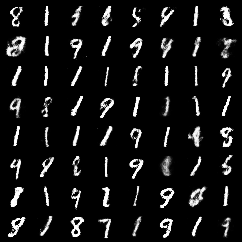



41/50 Sample of generated images


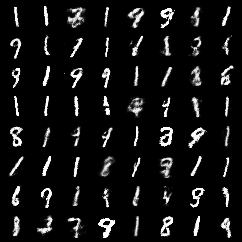



42/50 Sample of generated images


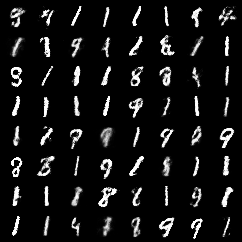



43/50 Sample of generated images


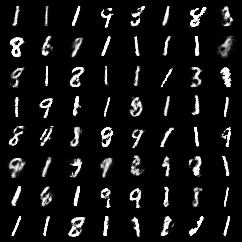



44/50 Sample of generated images


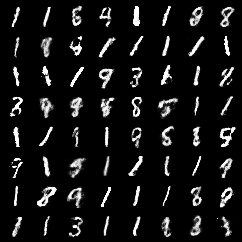



45/50 Sample of generated images


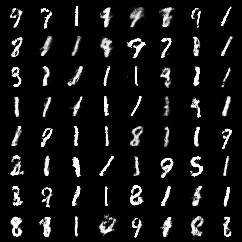



46/50 Sample of generated images


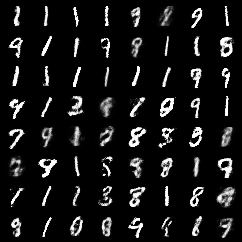



47/50 Sample of generated images


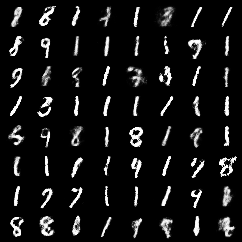



48/50 Sample of generated images


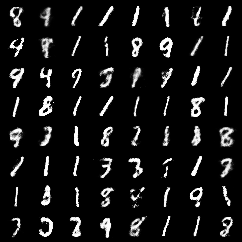



49/50 Sample of generated images


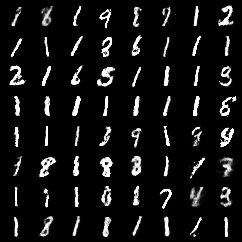



50/50 Sample of generated images


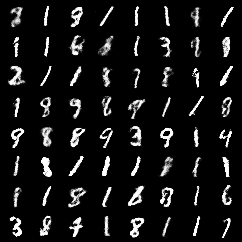

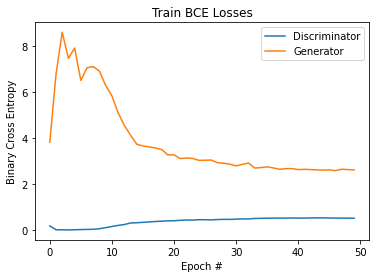

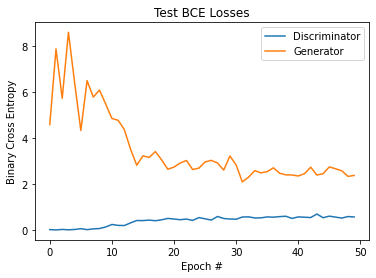

In [ ]:
epochs = 50
discriminator_average_train_losses = []
discriminator_average_test_losses = []
generator_average_train_losses = []
generator_average_test_losses = []
generator_model = Generator().to(device)
generator_optimizer = MAdam(generator_model.parameters(), lr=1e-3, betas=(0.9, 0.999, 0.9))
discriminator_model = Discriminator().to(device)
discriminator_optimizer = MAdam(discriminator_model.parameters(), lr=1e-3, betas=(0.9, 0.999, 0.9))
for epoch in range(1, epochs + 1):
    generator_average_train_loss, discriminator_average_train_loss = gan_train(epoch, generator_model, generator_optimizer, discriminator_model, discriminator_optimizer)
    discriminator_average_train_losses.append(discriminator_average_train_loss)
    generator_average_train_losses.append(generator_average_train_loss)
    generator_average_test_loss, discriminator_average_test_loss = gan_test(epoch, generator_model, discriminator_model)
    discriminator_average_test_losses.append(discriminator_average_test_loss)
    generator_average_test_losses.append(generator_average_test_loss)
    with torch.no_grad():
        print('%d/%d Sample of generated images' % (epoch, epochs))
        sample = torch.randn(64, 20).to(device)
        sample = generator_model(sample).cpu()
        if epoch == epochs:
            save_image(sample.view(64, 1, 28, 28),
                       'results/final_madam_sample.png')
            display(Image('results/final_madam_sample.png'))
        else:
            save_image(sample.view(64, 1, 28, 28),
                    'results/sample_' + str(epoch) + '.png')
            display(Image('results/sample_' + str(epoch) + '.png'))
        print('\n')

# Plot Train losses
plt.plot(discriminator_average_train_losses)
plt.plot(generator_average_train_losses)
plt.title('Train BCE Losses')
plt.ylabel('Binary Cross Entropy')
plt.xlabel('Epoch #')
plt.legend(['Discriminator','Generator'], loc='upper right')
plt.show()

# Plot Test Losses
plt.plot(discriminator_average_test_losses)
plt.plot(generator_average_test_losses)
plt.title('Test BCE Losses')
plt.ylabel('Binary Cross Entropy')
plt.xlabel('Epoch #')
plt.legend(['Discriminator','Generator'], loc='upper right')
plt.show()

torch.save(discriminator_average_train_losses, 'madam_gan_d_large_lr_train.pt')
torch.save(generator_average_train_losses, 'madam_gan_g_large_lr_train.pt')
torch.save(discriminator_average_test_losses, 'madam_gan_d_large_lr_test.pt')
torch.save(generator_average_test_losses, 'madam_gan_g_large_lr_test.pt')

/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:1639: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


1/50 Sample of generated images


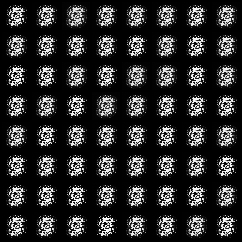



2/50 Sample of generated images


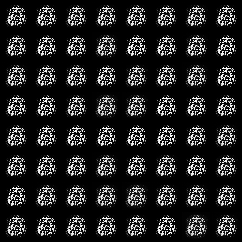



3/50 Sample of generated images


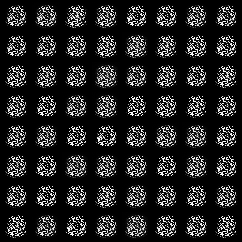



4/50 Sample of generated images


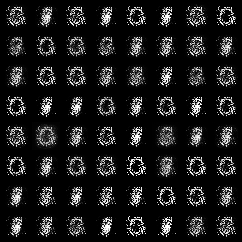



5/50 Sample of generated images


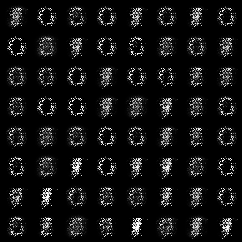



6/50 Sample of generated images


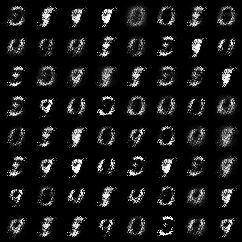



7/50 Sample of generated images


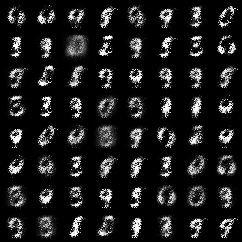



8/50 Sample of generated images


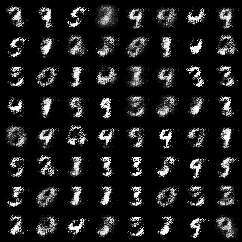



9/50 Sample of generated images


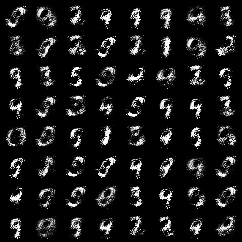



10/50 Sample of generated images


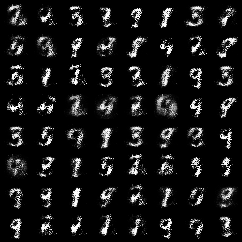



11/50 Sample of generated images


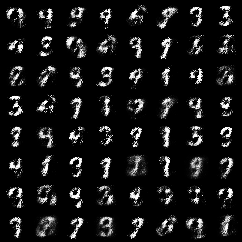



12/50 Sample of generated images


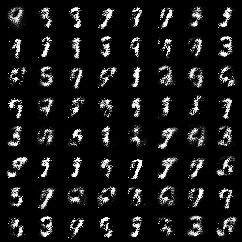



13/50 Sample of generated images


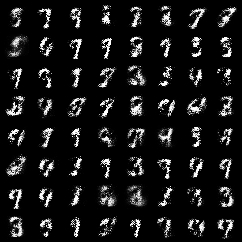



14/50 Sample of generated images


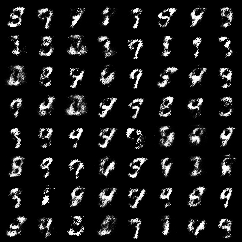



15/50 Sample of generated images


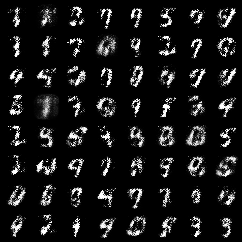



16/50 Sample of generated images


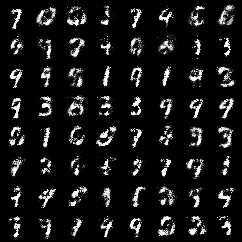



17/50 Sample of generated images


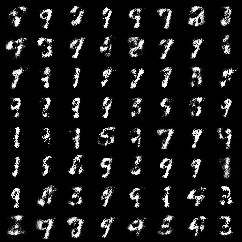



18/50 Sample of generated images


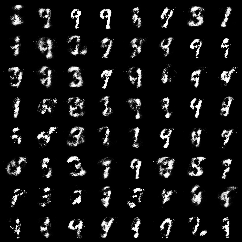



19/50 Sample of generated images


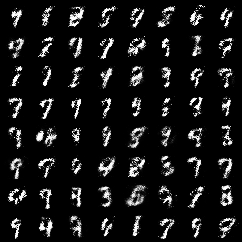



20/50 Sample of generated images


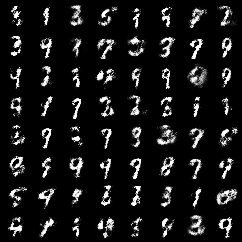



21/50 Sample of generated images


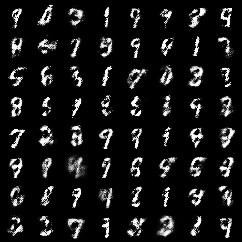



22/50 Sample of generated images


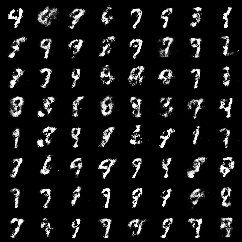



23/50 Sample of generated images


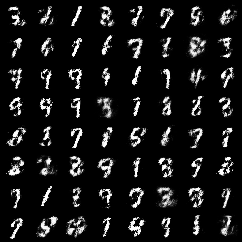



24/50 Sample of generated images


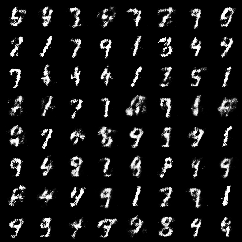



25/50 Sample of generated images


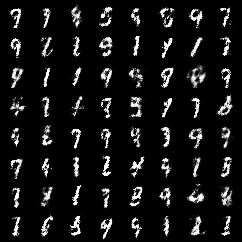



26/50 Sample of generated images


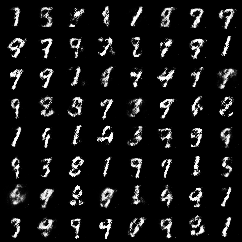



27/50 Sample of generated images


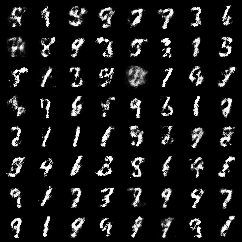



28/50 Sample of generated images


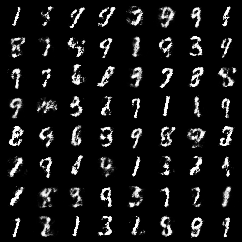



29/50 Sample of generated images


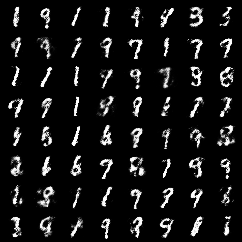



30/50 Sample of generated images


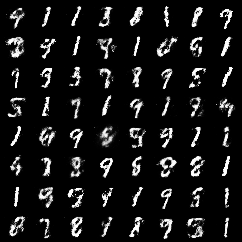



31/50 Sample of generated images


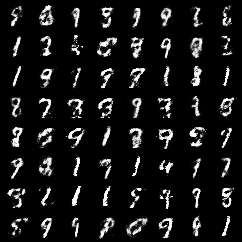



32/50 Sample of generated images


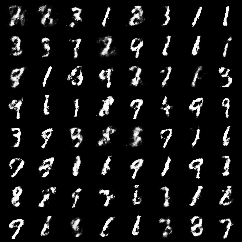



33/50 Sample of generated images


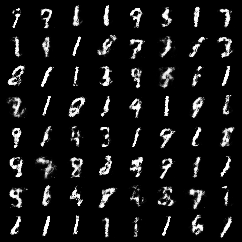



34/50 Sample of generated images


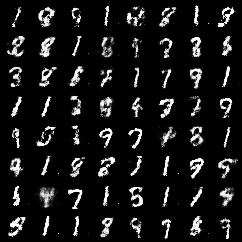



35/50 Sample of generated images


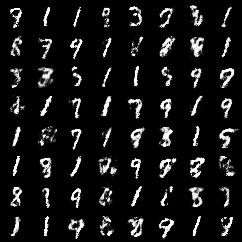



36/50 Sample of generated images


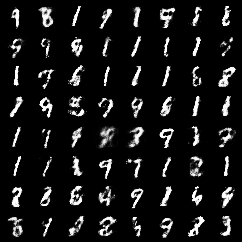



37/50 Sample of generated images


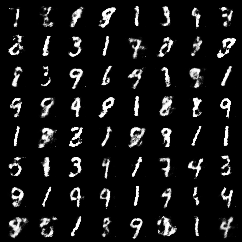



38/50 Sample of generated images


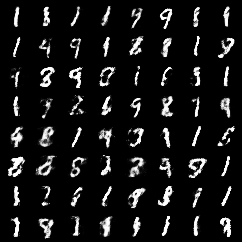



39/50 Sample of generated images


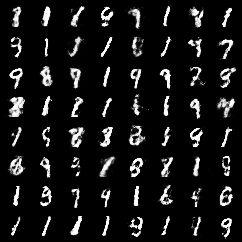



40/50 Sample of generated images


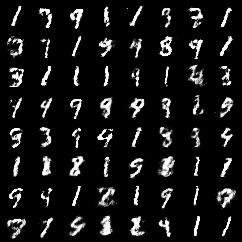



41/50 Sample of generated images


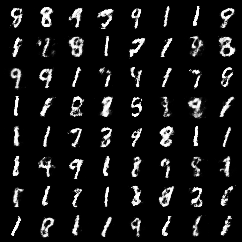



42/50 Sample of generated images


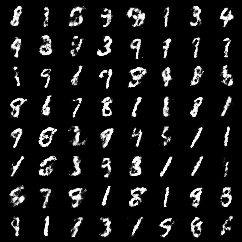



43/50 Sample of generated images


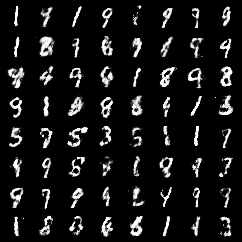



44/50 Sample of generated images


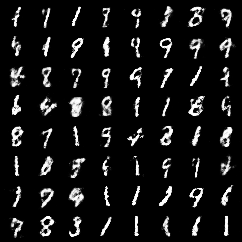



45/50 Sample of generated images


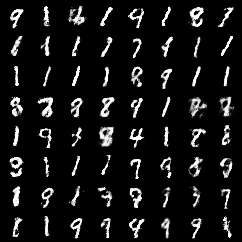



46/50 Sample of generated images


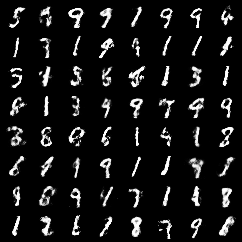



47/50 Sample of generated images


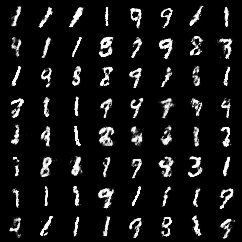



48/50 Sample of generated images


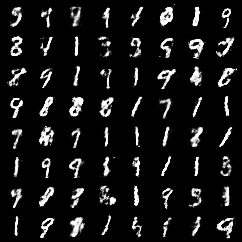



49/50 Sample of generated images


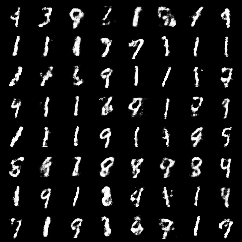



50/50 Sample of generated images


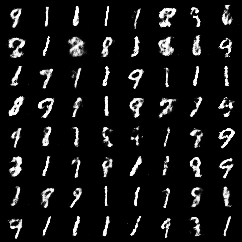

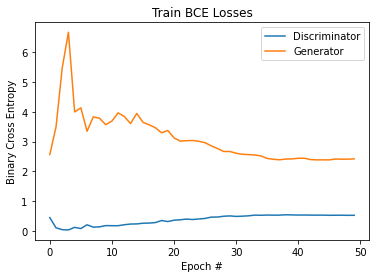

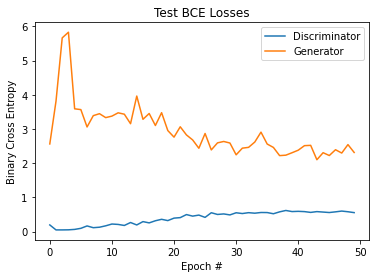

In [ ]:
epochs = 50
discriminator_average_train_losses = []
discriminator_average_test_losses = []
generator_average_train_losses = []
generator_average_test_losses = []
generator_model = Generator().to(device)
generator_optimizer = MAdam(generator_model.parameters(), lr=3e-4, betas=(0.9, 0.999, 0.6))
discriminator_model = Discriminator().to(device)
discriminator_optimizer = MAdam(discriminator_model.parameters(), lr=3e-4, betas=(0.9, 0.999, 0.6))
for epoch in range(1, epochs + 1):
    generator_average_train_loss, discriminator_average_train_loss = gan_train(epoch, generator_model, generator_optimizer, discriminator_model, discriminator_optimizer)
    discriminator_average_train_losses.append(discriminator_average_train_loss)
    generator_average_train_losses.append(generator_average_train_loss)
    generator_average_test_loss, discriminator_average_test_loss = gan_test(epoch, generator_model, discriminator_model)
    discriminator_average_test_losses.append(discriminator_average_test_loss)
    generator_average_test_losses.append(generator_average_test_loss)
    with torch.no_grad():
        print('%d/%d Sample of generated images' % (epoch, epochs))
        sample = torch.randn(64, 20).to(device)
        sample = generator_model(sample).cpu()
        if epoch == epochs:
            save_image(sample.view(64, 1, 28, 28),
                       'results/final_madam_sample.png')
            display(Image('results/final_madam_sample.png'))
        else:
            save_image(sample.view(64, 1, 28, 28),
                    'results/sample_' + str(epoch) + '.png')
            display(Image('results/sample_' + str(epoch) + '.png'))
        print('\n')

# Plot Train losses
plt.plot(discriminator_average_train_losses)
plt.plot(generator_average_train_losses)
plt.title('Train BCE Losses')
plt.ylabel('Binary Cross Entropy')
plt.xlabel('Epoch #')
plt.legend(['Discriminator','Generator'], loc='upper right')
plt.show()

# Plot Test Losses
plt.plot(discriminator_average_test_losses)
plt.plot(generator_average_test_losses)
plt.title('Test BCE Losses')
plt.ylabel('Binary Cross Entropy')
plt.xlabel('Epoch #')
plt.legend(['Discriminator','Generator'], loc='upper right')
plt.show()

torch.save(discriminator_average_train_losses, 'madam_gan_d_medium_lr_train.pt')
torch.save(generator_average_train_losses, 'madam_gan_g_medium_lr_train.pt')
torch.save(discriminator_average_test_losses, 'madam_gan_d_medium_lr_test.pt')
torch.save(generator_average_test_losses, 'madam_gan_g_medium_lr_test.pt')

/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:1639: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


1/50 Sample of generated images


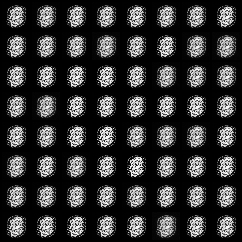



2/50 Sample of generated images


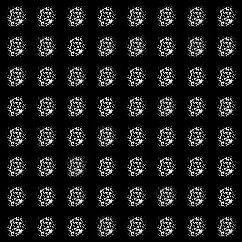



3/50 Sample of generated images


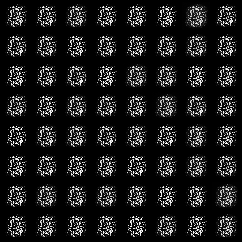



4/50 Sample of generated images


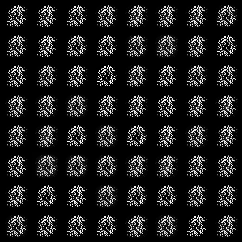



5/50 Sample of generated images


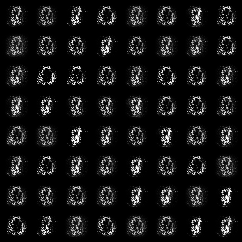



6/50 Sample of generated images


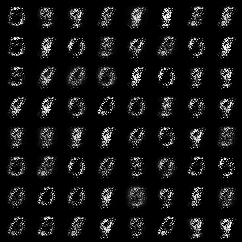



7/50 Sample of generated images


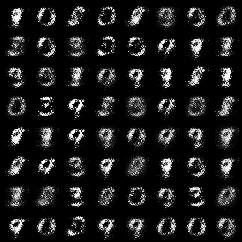



8/50 Sample of generated images


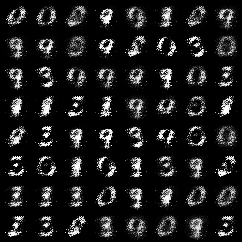



9/50 Sample of generated images


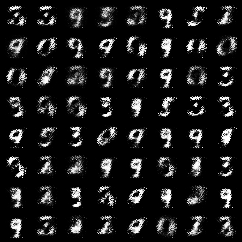



10/50 Sample of generated images


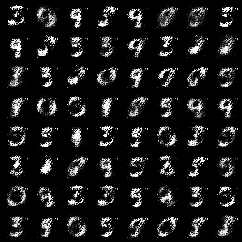



11/50 Sample of generated images


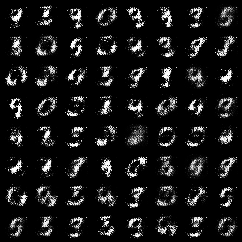



12/50 Sample of generated images


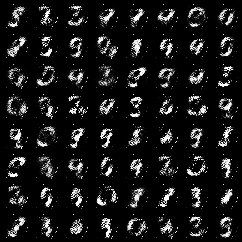



13/50 Sample of generated images


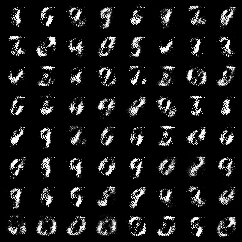



14/50 Sample of generated images


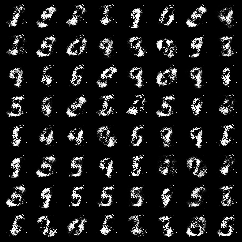



15/50 Sample of generated images


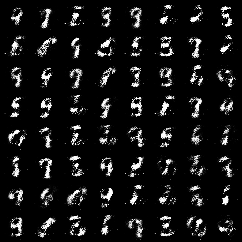



16/50 Sample of generated images


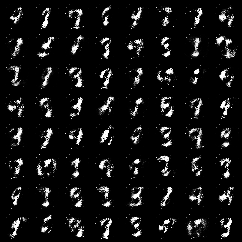



17/50 Sample of generated images


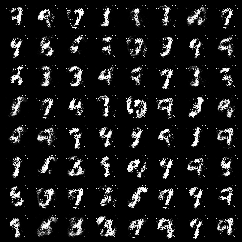



18/50 Sample of generated images


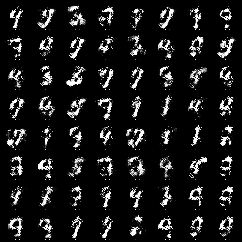



19/50 Sample of generated images


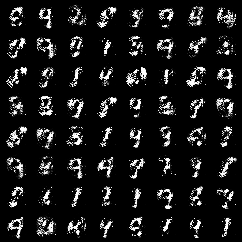



20/50 Sample of generated images


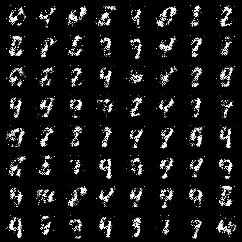



21/50 Sample of generated images


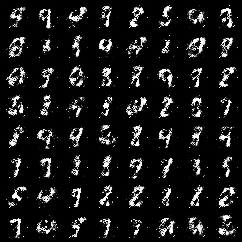



22/50 Sample of generated images


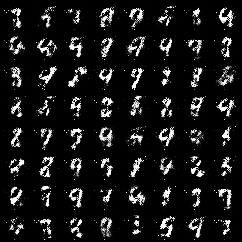



23/50 Sample of generated images


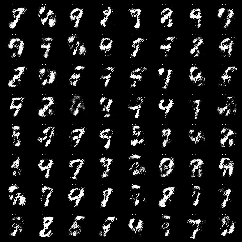



24/50 Sample of generated images


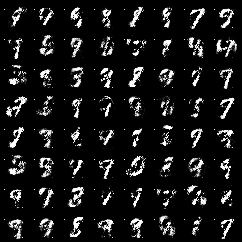



25/50 Sample of generated images


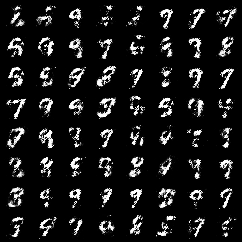



26/50 Sample of generated images


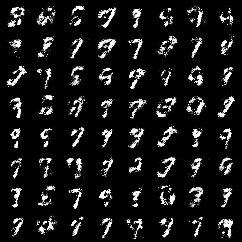



27/50 Sample of generated images


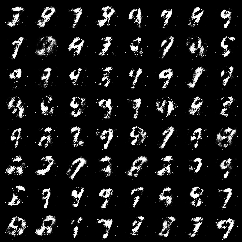



28/50 Sample of generated images


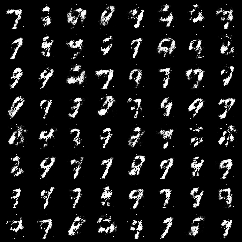



29/50 Sample of generated images


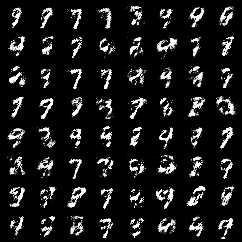



30/50 Sample of generated images


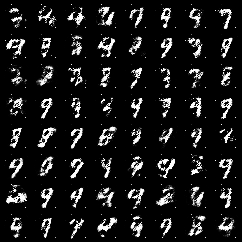



31/50 Sample of generated images


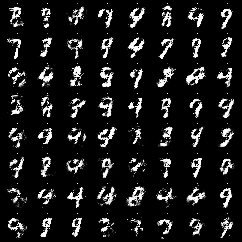



32/50 Sample of generated images


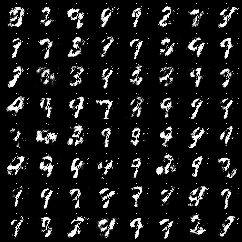



33/50 Sample of generated images


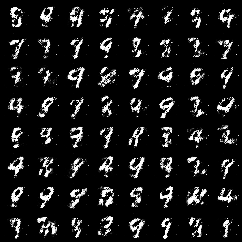



34/50 Sample of generated images


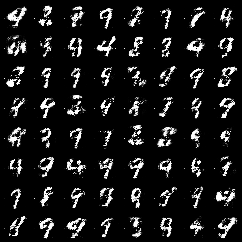



35/50 Sample of generated images


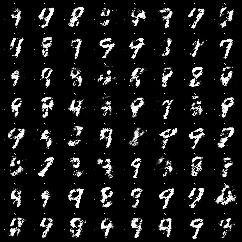



36/50 Sample of generated images


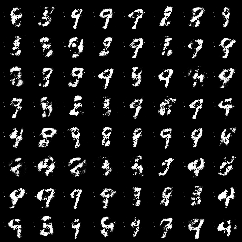



37/50 Sample of generated images


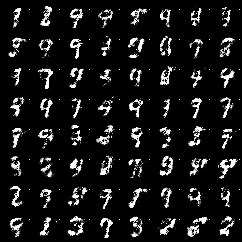



38/50 Sample of generated images


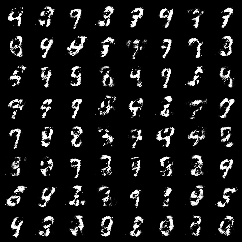



39/50 Sample of generated images


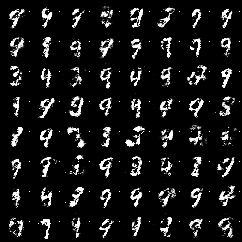



40/50 Sample of generated images


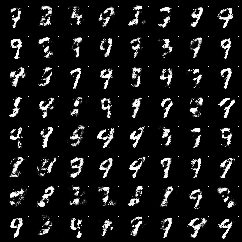



41/50 Sample of generated images


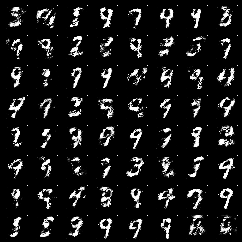



42/50 Sample of generated images


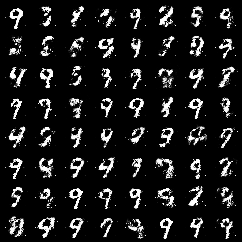



43/50 Sample of generated images


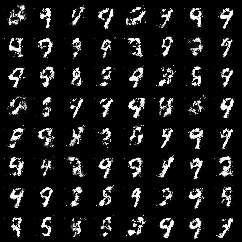



44/50 Sample of generated images


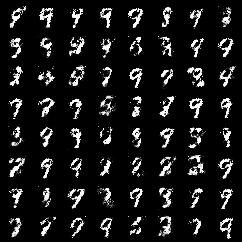



45/50 Sample of generated images


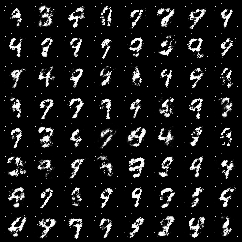



46/50 Sample of generated images


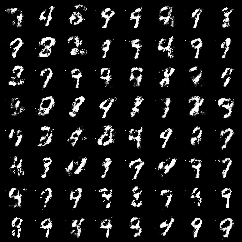



47/50 Sample of generated images


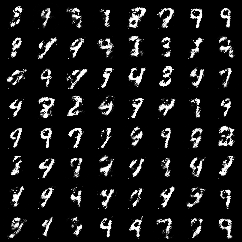



48/50 Sample of generated images


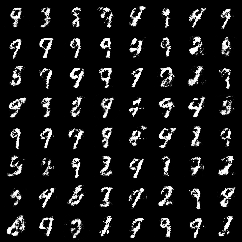



49/50 Sample of generated images


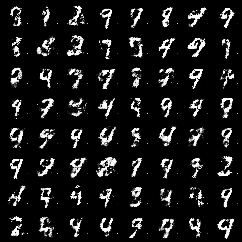



50/50 Sample of generated images


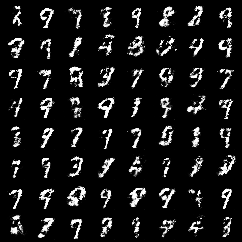

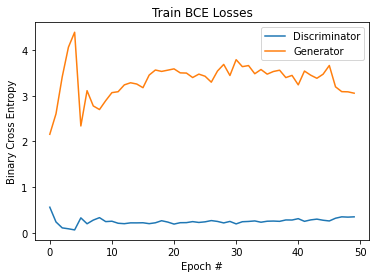

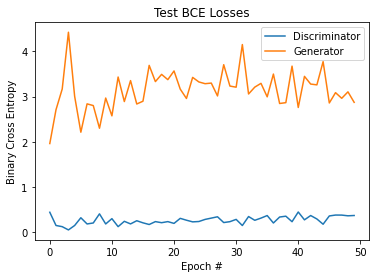

In [ ]:
epochs = 50
discriminator_average_train_losses = []
discriminator_average_test_losses = []
generator_average_train_losses = []
generator_average_test_losses = []
generator_model = Generator().to(device)
generator_optimizer = MAdam(generator_model.parameters(), lr=1e-4, betas=(0.9, 0.999, 0.18))
discriminator_model = Discriminator().to(device)
discriminator_optimizer = MAdam(discriminator_model.parameters(), lr=1e-4, betas=(0.9, 0.999, 0.18))
for epoch in range(1, epochs + 1):
    generator_average_train_loss, discriminator_average_train_loss = gan_train(epoch, generator_model, generator_optimizer, discriminator_model, discriminator_optimizer)
    discriminator_average_train_losses.append(discriminator_average_train_loss)
    generator_average_train_losses.append(generator_average_train_loss)
    generator_average_test_loss, discriminator_average_test_loss = gan_test(epoch, generator_model, discriminator_model)
    discriminator_average_test_losses.append(discriminator_average_test_loss)
    generator_average_test_losses.append(generator_average_test_loss)
    with torch.no_grad():
        print('%d/%d Sample of generated images' % (epoch, epochs))
        sample = torch.randn(64, 20).to(device)
        sample = generator_model(sample).cpu()
        if epoch == epochs:
            save_image(sample.view(64, 1, 28, 28),
                       'results/final_madam_sample.png')
            display(Image('results/final_madam_sample.png'))
        else:
            save_image(sample.view(64, 1, 28, 28),
                    'results/sample_' + str(epoch) + '.png')
            display(Image('results/sample_' + str(epoch) + '.png'))
        print('\n')

# Plot Train losses
plt.plot(discriminator_average_train_losses)
plt.plot(generator_average_train_losses)
plt.title('Train BCE Losses')
plt.ylabel('Binary Cross Entropy')
plt.xlabel('Epoch #')
plt.legend(['Discriminator','Generator'], loc='upper right')
plt.show()

# Plot Test Losses
plt.plot(discriminator_average_test_losses)
plt.plot(generator_average_test_losses)
plt.title('Test BCE Losses')
plt.ylabel('Binary Cross Entropy')
plt.xlabel('Epoch #')
plt.legend(['Discriminator','Generator'], loc='upper right')
plt.show()

torch.save(generator_average_test_losses, 'madam_gan_g_small_lr_test.pt')